Total Charge on the wire: -1.1085e-11 C
Total Capacitance: -1.1085e-11 F
Capacitance per unit length: -1.1085e-11 F/m


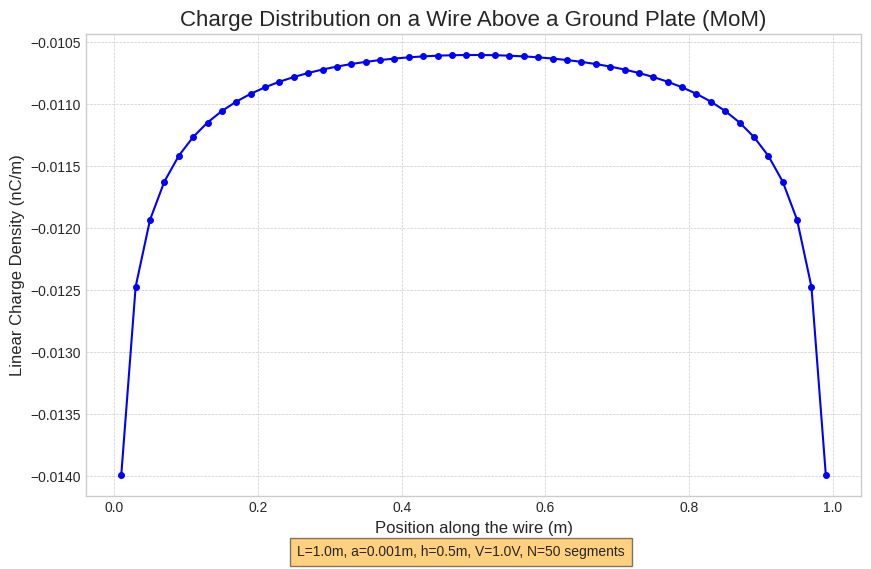

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_charged_wire_mom():
    """
    Solves for the charge distribution on a charged wire over a ground plate
    using the Method of Moments (MoM).
    """

    # --- 1. Define physical parameters ---
    L = 1.0          # Length of the wire (meters)
    a = 0.001        # Radius of the wire (meters)
    h = 0.5          # Height of the wire above the ground plate (meters)
    V0 = 1.0         # Voltage of the wire (Volts)
    N = 50           # Number of segments to discretize the wire into
    epsilon0 = 8.854e-12 # Permittivity of free space (F/m)

    # --- 2. Discretize the wire ---
    delta_L = L / N  # Length of each segment
    # x-coordinates of the center of each segment
    x_coords = np.linspace(delta_L / 2, L - delta_L / 2, N)

    # --- 3. Set up the MoM matrices ---
    Z = np.zeros((N, N))  # Impedance matrix (or potential coefficient matrix)
    V = np.full((N, 1), V0) # Voltage vector

    # --- 4. Populate the impedance matrix Z ---
    # The element Z_ij represents the potential at the center of segment i
    # due to a unit charge density on segment j.
    # We use the method of images to account for the ground plate.

    for i in range(N):
        for j in range(N):
            # Observation point (center of segment i)
            x_i = x_coords[i]

            # Source segment j boundaries
            x_j_start = x_coords[j] - delta_L / 2
            x_j_end = x_coords[j] + delta_L / 2

            # --- Potential from the charge on the actual wire ---
            # We use the exact integral for the potential of a finite line charge
            # to avoid singularities and improve accuracy.
            # The potential phi at a point P due to a line segment with charge density lambda is:
            # phi = (lambda / 4*pi*eps0) * ln[(L2 + sqrt(L2^2 + a^2)) / (L1 + sqrt(L1^2 + a^2))]
            # where L1 and L2 are the distances from P to the ends of the segment.

            # Distances from the center of segment i to the ends of segment j
            L1_real = x_i - x_j_start
            L2_real = x_i - x_j_end

            # The 'a' in the formula is the perpendicular distance.
            # When i == j, the observation point is on the axis of the source segment,
            # so the perpendicular distance is the wire radius 'a'.
            # When i != j, the observation point is at a horizontal distance |x_i - x_j|.
            # We use the wire radius 'a' as the effective distance for the self-term
            # and the center-to-center distance for off-diagonal terms.
            # This is a common approximation for thin wires.
            dist_real = np.sqrt((x_i - x_coords[j])**2 + a**2)

            # Potential contribution from the real wire segment j
            # We are calculating the coefficient for a unit charge on the segment (lambda * delta_L = 1)
            # So, lambda = 1 / delta_L
            term1_real = L2_real + np.sqrt(L2_real**2 + dist_real**2)
            term2_real = L1_real + np.sqrt(L1_real**2 + dist_real**2)
            potential_real = (1 / (4 * np.pi * epsilon0 * delta_L)) * np.log(term1_real / term2_real)


            # --- Potential from the charge on the image wire ---
            # The image wire is at z = -h. The observation point is at z = h.
            # The perpendicular distance is always sqrt((x_i - x_j)^2 + (2h)^2)
            dist_image = np.sqrt((x_i - x_coords[j])**2 + (2 * h)**2)

            # Distances from the center of segment i to the ends of the image segment j
            L1_image = x_i - x_j_start
            L2_image = x_i - x_j_end

            # Potential contribution from the image wire segment j
            # The image charge has opposite sign, hence the minus sign.
            term1_image = L2_image + np.sqrt(L2_image**2 + dist_image**2)
            term2_image = L1_image + np.sqrt(L1_image**2 + dist_image**2)
            potential_image = (1 / (4 * np.pi * epsilon0 * delta_L)) * np.log(term1_image / term2_image)

            # The total potential is the sum of the real and image contributions.
            # The image charge is opposite, so we subtract its potential contribution.
            Z[i, j] = potential_real - potential_image


    # --- 5. Solve for the charge distribution ---
    # Solve the matrix equation [Z][q] = [V] for the charge vector [q]
    # where q is the charge on each segment.
    q = np.linalg.solve(Z, V)

    # Convert charge per segment to linear charge density (C/m)
    lambda_charge_density = q / delta_L

    # --- 6. Calculate total charge and capacitance ---
    total_charge = np.sum(q)
    capacitance = total_charge / V0
    capacitance_per_unit_length = capacitance / L

    print(f"Total Charge on the wire: {total_charge:.4e} C")
    print(f"Total Capacitance: {capacitance:.4e} F")
    print(f"Capacitance per unit length: {capacitance_per_unit_length:.4e} F/m")


    # --- 7. Plot the results ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x_coords, lambda_charge_density * 1e9, 'b-o', markersize=4)
    ax.set_title('Charge Distribution on a Wire Above a Ground Plate (MoM)', fontsize=16)
    ax.set_xlabel('Position along the wire (m)', fontsize=12)
    ax.set_ylabel('Linear Charge Density (nC/m)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.figtext(0.5, 0.01, f'L={L}m, a={a}m, h={h}m, V={V0}V, N={N} segments',
                ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    plt.show()


if __name__ == '__main__':
    solve_charged_wire_mom()